# 1. Method description

In this method we run 2 executions of KMeans in parallel:
- The first one runs on the full dataset, and performs A, and then B. A -> B
- The second one runs over a subset of the dataset, and performs A, and then B, multiple times. We describe this as a-> b -> a -> b -> ... -> b. We use small a,b to indicate we are using a subset of the dataset.

We then compute:
- L_slow, the average distance from each point to its centroid, using the centroids obtained from the first slow execution
- L_fast, the average distance from each point to its centroid, using the centroids obtained from the second fast execution

Afterwards, we compare L_slow and L_fast: we select the centroids of the lowest one.

The idea is that we can distinguish 2 phases in KMeans:
- the first phase we try to move the centroids from the initialization points near to the respective clusters. We may not need the whole dataset in this phase, and that's why the second and faster execution of KMeans may help
- the second phase start when we almost found the correct position of the centroids and the respective clusters. We are not trying to converge by fixing the last datapoints which are not correctly classified. In this phase is more critical to use the whole dataset, since we need to make small updates of the centroids, which are critical for the convergence.

Let's call L the average distance between datapoints and their centroids.

We expect that:
- L_slow is going to be greater than L_fast in the first phase, so we will benefit from the execution of the second fast run.
- L_slow is going to be less than L_fast in the second phase, so we will no more benefit from the execution of the second fast run. *In this case we may switch to only data parallelism.*

# 2. Measurements L_slow - L_fast 

In this section we study how L_slow - L_fast evolves during the KMeans execution.

As we said before:
We expect that:
- L_slow is going to be greater than L_fast in the first phase, so we will benefit from the execution of the second fast run.
- L_slow is going to be less than L_fast in the second phase, so we will no more benefit from the execution of the second fast run. 

Let's call L_diff = (L_slow - L_fast).

We therefore **expect to see L_diff increasing** during the convergence of KMeans.

In [75]:
%load_ext autoreload
%autoreload 2
from utils.helpers import generate_clusters, timeseries_plot
from KMeans import KMeans, getLables, getCentroids, getAvgDist, KMeans_sketching
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# set seed = 0
seed = 0
np.random.seed(seed)
# define parameters
n = 100000
d = 2
k = 3
subsample_size = 0.01
# create synthetic dataset
true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

## Single execution

In [45]:
# initialize centroids
np.random.seed(seed)
centroids = X[np.random.choice(n, k, replace=False)]

In [46]:
# slow execution

# A - Assignment step
labels = getLables(X, centroids) 
# B - Update step
centroids = getCentroids(X, labels, k)
# Compute avg distance
L_slow = getAvgDist(X, centroids)

In [47]:
# fast execution

# Subsampling
np.random.seed(seed)
subsample_size = 0.01
mask = np.random.choice([True, False], size=X.shape[0], p=[subsample_size, 1-subsample_size])

# Number of executions n_executions = 1/subsample_size
n_executions = int(np.floor(1/subsample_size))

# Execute a,b n_execution times
for i in range(n_executions):
    # A - Assignment step
    labels = getLables(X[mask], centroids) 
    # B - Update step
    centroids = getCentroids(X[mask], labels, k)
    
# Compute avg distance - we use the whole dataset X now!
L_fast = getAvgDist(X, centroids)

In [48]:
# compute L_diff

L_diff = L_fast - L_slow
L_diff

-0.48168707313829673

## Entire execution

In [93]:
# entire execution
fast_labels_list, fast_centroids_list, slow_labels_list, slow_centroids_list, L_slow_list, L_fast_list, L_diff_list = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size)

## Timeseries plot

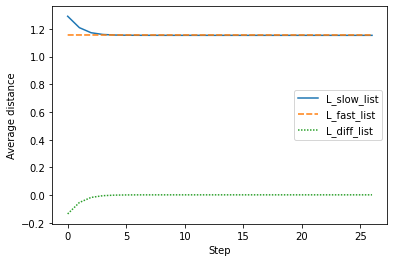

In [94]:
timeseries_plot([L_slow_list, L_fast_list, L_diff_list], ['L_slow_list', 'L_fast_list', 'L_diff_list'], xlabel='Step', ylabel='Average distance')

# Plots

In [ ]:
def plot_kmeans_evolution_2D(X, x1, x2, labels_list, centroids_list):
    df = pd.DataFrame(columns=['x1','x2','labels','type','step'])
    for step in range(len(slow_labels_list)):
        df1 = pd.DataFrame(data=X[], )
        df1['labels'] = slow_labels_list[step]
        df1['type'] = 'datapoint'
        df1['step'] = step
        df2 = pd.DataFrame(data=slow_centroids_list[step])
        df2['labels'] = -1
        df2['type'] = 'centroid'
        df2['step'] = step
        df3 = pd.concat([df1, df2])
        df = pd.concat([df, df3])
    df.labels = df.labels.astype('category')

In [65]:
df = pd.DataFrame(columns=[0,1,'labels','type','step'])
for step in range(len(slow_labels_list)):
    df1 = pd.DataFrame(data=X, )
    df1['labels'] = slow_labels_list[step]
    df1['type'] = 'datapoint'
    df1['step'] = step
    df2 = pd.DataFrame(data=slow_centroids_list[step])
    df2['labels'] = -1
    df2['type'] = 'centroid'
    df2['step'] = step
    df3 = pd.concat([df1, df2])
    df = pd.concat([df, df3])
df.labels = df.labels.astype('category')

In [66]:
df_fast = pd.DataFrame(columns=[0,1,'labels','type','step'])
for step in range(len(slow_labels_list)):
    df1 = pd.DataFrame(data=X, )
    df1['labels'] = fast_labels_list[step]
    df1['type'] = 'datapoint'
    df1['step'] = step
    df2 = pd.DataFrame(data=fast_centroids_list[step])
    df2['labels'] = -1
    df2['type'] = 'centroid'
    df2['step'] = step
    df3 = pd.concat([df1, df2])
    df_fast = pd.concat([df_fast, df3])
df_fast.labels = df_fast.labels.astype('category')

## Plot

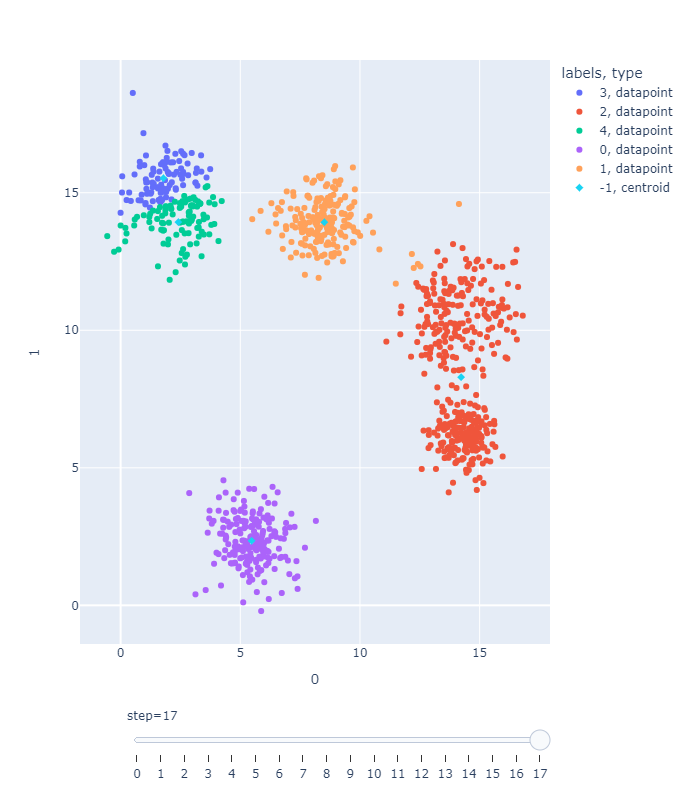

In [67]:
import plotly.express as px

fig = px.scatter(df, x=0, y=1, animation_frame="step", color="labels", symbol ='type', width=800, height=800)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

## import plotly.express as px

fig = px.scatter(df_fast, x=0, y=1, animation_frame="step", color="labels", symbol ='type', width=800, height=800)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [60]:
L_diff_list

array([-0.45872624,  0.58765938,  0.59045245,  0.59045245])